In [1]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from analysis_utils import *
from scipy.stats import norm

os.chdir('../')
os.getcwd()

'/Users/sumiyaabdirashid/Desktop/PhD/code/git/PRF_Experiment_Checkers/Experiment'

Load data into Pandas dataframe. To be implemented: run some tests to ensure data quality

- does run exist? 
- does run contain responses?
- does run log color_balance and fix_intensity values correctly?

# Analysis of 2AFC Attn Task

In psychophysics task participants respond to each trial indicating whether the stimulus presented is more dark or more light.

**Note:** Response Left (color_balance < 0.5) = Dark; Response Right (color_balance > 0.5) = Light.

In [188]:
f_names = glob.glob("logs/psychophys/*/*.tsv")
all_logs = load_data(f_names)
all_logs[all_logs.run == '2'].head(10)

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,run
450,0,0.027320,stim,0,NaN,169.0,0.1,0.8,4.415654,3.952342,3.979662,8.367996,Logs,2
451,0,3.947723,response,0,left,0.0,0.1,0.8,8.336057,0.000000,3.947723,8.336057,Logs,2
452,1,3.979662,stim,0,NaN,100.0,0.1,0.8,8.367996,2.822325,6.801987,11.190321,Logs,2
453,1,6.753271,response,0,left,0.0,0.1,0.8,11.141605,0.000000,6.753271,11.141605,Logs,2
454,2,6.801987,stim,0,NaN,46.0,0.1,0.6,11.190321,1.660958,8.462945,12.851279,Logs,2
455,2,8.421417,response,0,right,0.0,0.1,0.6,12.809751,0.000000,8.421417,12.809751,Logs,2
456,3,8.462945,stim,0,NaN,53.0,0.9,0.8,12.851279,1.567279,10.030225,14.418558,Logs,2
457,3,9.996076,response,0,right,0.0,0.9,0.8,14.384410,0.000000,9.996076,14.384410,Logs,2
458,4,10.030225,stim,0,NaN,61.0,0.9,-0.6,14.418558,1.499834,11.530058,15.918392,Logs,2
459,4,11.496236,response,0,right,0.0,0.9,-0.6,15.884569,0.000000,11.496236,15.884569,Logs,2


In [211]:
df = all_logs[(all_logs.event_type == 'response') & (all_logs.run == '2')]
fixed = np.append(np.array(df.color_balance)[1:],[np.array(df.color_balance)[-1]])
df.color_balance = fixed
df['correct'] = np.nan

true_left = df[(df.color_balance < 0.5) & (df.response == 'left')].index
false_left = df[(df.color_balance > 0.5) & (df.response == 'left')].index

true_right = df[(df.color_balance > 0.5) & (df.response == 'right')].index
false_right = df[(df.color_balance < 0.5) & (df.response == 'right')].index

print(f'Total response "right": {sum(df.response == "left")} \
    \nTotal response "left": {sum(df.response == "right")} \
    \ntrue_left: {len(true_left)/sum(df.color_balance < 0.5)} \
    \ntrue_right: {len(true_right)/sum(df.color_balance > 0.5)} \
    \nfalse_left: {len(false_left)/sum(df.color_balance < 0.5)} \
    \nfalse_right: {len(false_right)/sum(df.color_balance > 0.5)}')

Total response "right": 109     
Total response "left": 116     
true_left: 0.9814814814814815     
true_right: 0.9743589743589743     
false_left: 0.027777777777777776     
false_right: 0.017094017094017096


In [212]:
df.loc[np.hstack((true_left,true_right)), 'correct'] = 1
df.loc[np.hstack((false_left,false_right)), 'correct'] = 0
df = df.dropna() # drop where color balance = 0.5
df.head()

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,run,correct
451,0,3.947723,response,0,left,0.0,0.1,0.8,8.336057,0.0,3.947723,8.336057,Logs,2,1.0
453,1,6.753271,response,0,left,0.0,0.1,0.8,11.141605,0.0,6.753271,11.141605,Logs,2,1.0
455,2,8.421417,response,0,right,0.0,0.9,0.6,12.809751,0.0,8.421417,12.809751,Logs,2,1.0
457,3,9.996076,response,0,right,0.0,0.9,0.8,14.384410,0.0,9.996076,14.384410,Logs,2,1.0
459,4,11.496236,response,0,right,0.0,0.9,-0.6,15.884569,0.0,11.496236,15.884569,Logs,2,1.0


Plot response light v.s. proportion light. Should increase together

% Light: 0.1, 	% Response Light 1.9
% Light: 0.9, 	% Response Light 97.4


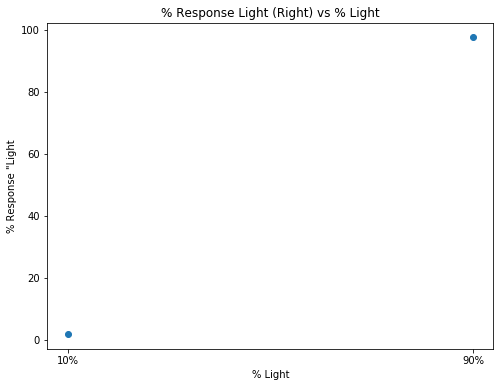

In [213]:
difficulties = sorted(df[(df.run == '2')].color_balance.unique())
proportions = []

for diff in difficulties:
    print(f'% Light: {diff}, \t% Response Light {round(len(df[(df.color_balance == diff) & (df.response == "right")]) / len(df[df.color_balance == diff]) *100,1)}')
    proportions.append(len(df[(df.color_balance == diff) & (df.response == "right")]) / len(df[df.color_balance == diff]) *100)

fig, axs = plt.subplots(1,1, figsize=(8,6))

axs.set_title('% Response Light (Right) vs % Light')
axs.set_ylabel('% Response "Light')
axs.set_xlabel('% Light')
axs.scatter([f'{int(i*100)}%' for i in difficulties],proportions)

Plot difficulty v.s. proportion correct

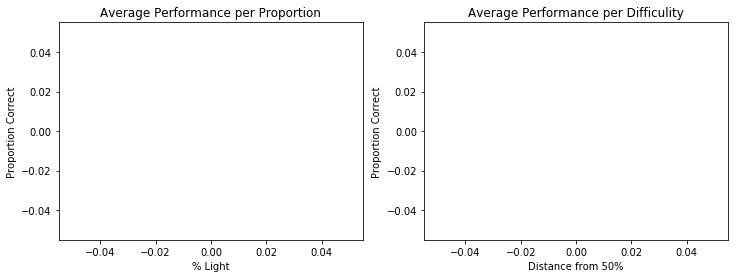

In [198]:
difficulties = sorted(df[(df.run == '13')].color_balance.unique())
proportions = []

for diff in difficulties:
    print(f'Color balance: {abs(0.5 - diff):.2f}, prop_correct:{sum(df[df.color_balance == diff].correct)/len(df[df.color_balance == diff].correct):.2f}')
    proportions.append(sum(df[df.color_balance == diff].correct)/len(df[df.color_balance == diff].correct))

fig, axs = plt.subplots(1,2, figsize=(12,4))

axs[0].set_title('Average Performance per Proportion')
axs[0].set_ylabel('Proportion Correct')
axs[0].set_xlabel('% Light')
axs[0].scatter([f'{int(i*100)}%' for i in difficulties],proportions)

axs[1].set_title('Average Performance per Difficulity')
axs[1].set_ylabel('Proportion Correct')
axs[1].set_xlabel('Distance from 50%')
axs[1].scatter([int(abs(0.5-i)*100) for i in difficulties],proportions)

# Analysis of Attn PRF Detection Task

In [113]:
f_names = glob.glob("logs/*/*.tsv")
all_logs = load_data(f_names)
all_logs[(all_logs.run == '12')].head()

,trial_nr,onset,event_type,phase,response,nr_frames,color_balance,fix_intensity,onset_abs,duration,end,end_abs,task,run
1494,0,0.033202,stim,0,NaN,41.0,0.5,0.0,4.961443,0.344763,0.377965,5.306206,smallAF,12
1495,0,0.753004,stim,2,NaN,45.0,0.5,0.0,5.681244,0.374961,1.127964,6.056205,smallAF,12
1496,1,1.503000,stim,0,NaN,45.0,0.5,0.0,6.431241,0.374959,1.877959,6.806200,smallAF,12
1497,1,2.252952,stim,2,NaN,45.0,0.5,0.0,7.181192,0.374974,2.627925,7.556166,smallAF,12
1498,2,3.002946,stim,0,NaN,44.0,0.5,0.0,7.931187,0.375006,3.377952,8.306193,smallAF,12


Calculate correct and incorrect responses. Use this to get hits (true positives), misses (false negatives), false alarms (false positives) and correct rejections (true negatives). Once we have these values we can calculate d' and the criterion (c). 

### Summary per run

In [114]:
psyc, d_primes, large_cor, small_cor = analyse_logs(all_logs)
psyc

,run,task,hits,misses,fas,correjs,dprime,criterion,difficulties
0,7,color_balance,60,28,1,333,3.221226,1.137824,"[0.25, 0.3, 0.5, 0.7, 0.75]"
1,8,fix_intensity,34,54,3,307,2.049816,1.313717,"[-0.05, -0.03, 0.0, 0.03, 0.05]"
2,9,color_balance,34,38,1,339,2.684583,1.411977,"[0.2, 0.4, 0.5, 0.6, 0.7]"
3,10,fix_intensity,47,25,3,352,2.781676,0.998007,"[-0.07, -0.06, 0.0, 0.06, 0.07]"
4,11,color_balance,35,37,1,340,2.720408,1.395025,"[0.35, 0.45, 0.5, 0.65, 0.8]"
5,12,fix_intensity,31,41,6,336,1.932385,1.141152,"[-0.09, -0.02, 0.0, 0.02, 0.09]"


We can also calculate d' per difficulty level and plot this to see if two task difficulties are comparable. Unfortunately d' can go to infinity so many points are missing from the performance curves... and we're unsure if they're sigmoidal.

In [115]:
Z = norm.ppf
d_primes['d_prime']= Z(d_primes['hit_rate'])- Z(d_primes['fa_rate'])
d_primes['criterion'] = -(Z(d_primes['hit_rate']) + Z(d_primes['fa_rate'])) / 2
d_primes.head()

,run,task,difficulty,hit_rate,fa_rate,d_prime,criterion
0,7,color_balance,0.25,0.909091,0.002994,4.083614,0.706629
1,7,color_balance,0.30,0.500000,0.002994,2.748436,1.374218
2,7,color_balance,0.70,0.636364,0.002994,3.097192,1.199840
3,7,color_balance,0.75,0.681818,0.002994,3.221226,1.137824
4,8,fix_intensity,-0.05,0.590909,0.009677,2.568509,1.054371


In [116]:
large_AF = d_primes[d_primes['run'].astype(int) % 2 == 1]
small_AF = d_primes[d_primes['run'].astype(int) % 2 == 0]

Text(0, 0.5, 'Dprime')

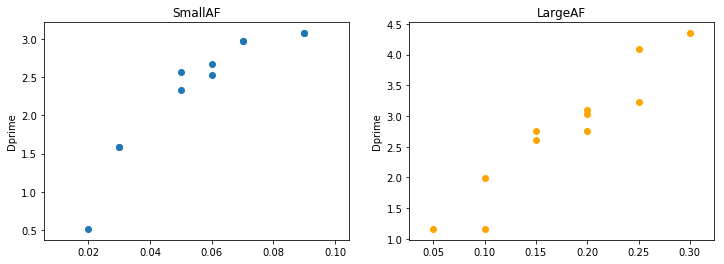

In [117]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,4))

ax1.set_title('SmallAF')
ax1.scatter(abs(small_AF['difficulty']),small_AF['d_prime'])
ax1.set_ylabel('Dprime')

ax2.set_title('LargeAF')
ax2.scatter(abs(large_AF['difficulty']-0.5),large_AF['d_prime'],color='orange')
ax2.set_ylabel('Dprime')

We can also use proportion correct to create psychometric curves - although these are not traditional sigmoidal psychometric curves which are designed for 2 alternative forced-choice (2AFC) task. 

In [118]:
largex, largey = (np.array([i[0] for i in large_cor]), 
                  np.array([i[1] for i in large_cor]))
smallx,smally = (np.array([i[0] for i in small_cor]), 
                np.array([i[1] for i in small_cor]))

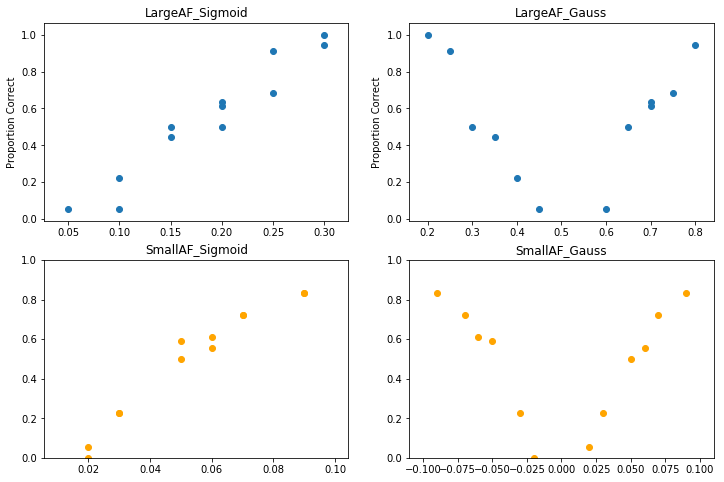

In [119]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,8))

ax1.set_title('LargeAF_Sigmoid')
ax1.scatter([abs(i[0]-0.5) for i in large_cor], [i[1] for i in large_cor])
ax1.set_ylabel('Proportion Correct')

ax2.set_title('LargeAF_Gauss')
ax2.scatter([i[0] for i in large_cor], [i[1] for i in large_cor])
ax2.set_ylabel('Proportion Correct')

ax3.set_title('SmallAF_Sigmoid')
ax3.set_ylim(0,1)
ax3.scatter([abs(i[0]-0) for i in small_cor], [i[1] for i in small_cor], color='orange')

ax4.set_title('SmallAF_Gauss')
ax4.set_ylim(0,1)
ax4.scatter([i[0] for i in small_cor], [i[1] for i in small_cor], color='orange')

Lastly we can fit a sigmoid function to each of these curves.

[ 0.17465133 19.68596984]


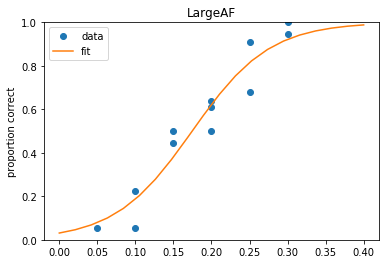

[5.27731781e-02 5.75644180e+01]


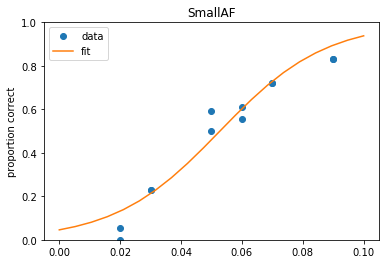

In [120]:
def sigmoid(x, x0, k):
     y = 1 / (1 + np.exp(-k*(x-x0)))
     return y

xdata = abs(largex-0.5) # abs(large_AF['difficulty']-0.5)[large_AF.replace([np.inf,-np.inf],np.nan).dropna().index]
ydata = largey # large_AF.replace([np.inf,-np.inf],np.nan).dropna()['d_prime']

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

x = np.linspace(0.0, 0.4, 20)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.title('LargeAF')
plt.plot(x,y, label='fit')
plt.ylim(0, 1)
plt.ylabel('proportion correct')
plt.legend(loc='best')
plt.show()

xdata = abs(smallx) # abs(small_AF['difficulty'])[small_AF.replace([np.inf,-np.inf],np.nan).dropna()['d_prime'].index]
ydata = smally # small_AF.replace([np.inf,-np.inf],np.nan).dropna()['d_prime']

popt, pcov = curve_fit(sigmoid, xdata, ydata)
print(popt)

x = np.linspace(0.0, 0.1, 20)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, 'o', label='data')
plt.title('SmallAF')
plt.plot(x,y, label='fit')
plt.ylim(0, 1)
plt.ylabel('proportion correct')
plt.legend(loc='best')
plt.show()

# Modeling psychometric curve

In [ ]:
def model_pr():
    '''
    return array of probabilities corresponding to GAUSSIAN cdf
    stimuli is range of color_balances / fix intensities
    loc
    sd / scale
    '''
    
    stim_x = np.arange(0,0.6,0.05)
    mu = 0.3
    sd = 0.1
    
    model_pr = norm.cdf(stim_x, mu,sd)
    
    return stim_x, model_pr

In [ ]:
x,pr = model_pr()
plt.plot(x, pr, color='k', marker='x', lw=2, ls='--')
plt.xlim(0,0.6)
plt.ylim(0,1)
plt.show()